## Instructions

In this ~bonus lab~ business case study, you will be using the Sakila database of movie rentals. Choose one of the cases below, or both if you dare:

**Case 1:**

We will be trying to predict if a **customer will be renting a film** this month based on their previous activity and other details. We will first construct a table with:

    Customer ID
    City
    Most rented film category
    Total films rented
    Total money spent
    How many films rented last month (MAY/2005)
    If the customer rented a movie this month (JUNE/2005)

Once you extract that information, and any other that seems fit, predict which customers will be renting this month.

**Case 2:**

We will be trying to predict if a **film will be rented** this month based on their previous activity and other details. We will first construct a table with:

    Film ID
    Category
    Total number of copies
    *Bonus - How many "stars" actrs. in the film *
    How many times the film was rented last month (MAY/2005)
    If the film was rented this month (JUNE/2005)

Once you extract that information, and any other that seems fit, predict which customers will be renting this month.

**Suggestions:**

Format your notebook as a report, in a way that someone who didn't know your project could read and understand.

Explain any transformation/scaling/feature engineering you apply (no need to explain data cleaning steps).

Write some conclusions: how would this prediction impact the business? what are your constraints in this business case? is it a good predictive model? any problems you suspect of? any ideas on how to solve the problem and/or improve the model?

**Bonus - Challenge:** Choose another target variable and explore other possibilities of predictions. Make sure to explain your business application and hypothesis.

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # to get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
data = pd.read_sql_query('''select c.customer_id, ci.city, sum(p.amount) as "total_amount_paid", favorite_categ, count(r.rental_id) as 'times_renting', june_rentals, coalesce(may_rentals, 0) as 'may_rentals' from customer c -- c.customer_id, ci.city, max(count(fc.film_category)), sum(p.amount), count(rental_id) from rentals_june where monthname(rental_date) = 'May' as 'May_rentals', case (when monthname(rental_date) as'June' then 1 else 0 from customer)) end as 'June_rentals' from customer c
left join rental r on c.customer_id = r.customer_id
left join address a on c.address_id = a.address_id
left join city ci on a.city_id = ci.city_id
left join payment p on r.rental_id= p.rental_id
left join inventory i on r.inventory_id = i.inventory_id
left join film f on i.film_id = f.film_id
left join film_category fc on f.film_id = fc.film_id
left join category cat on fc.category_id = cat.category_id
-- where category_id = select * from (count(film_id) from film_category group by category_id)
join (select *, 
case 
	when sum(monthname(rental_date) = 'June') > 0 then 1 
    else 0
end as 'june_rentals'
from rental
group by customer_id) jr on r.customer_id = jr.customer_id
left join (select customer_id, rental_id, count(rental_id) as 'may_rentals'
from rental
where monthname(rental_date) = 'May' 
group by customer_id) mr on r.rental_id = mr.rental_id
left join (select c.customer_id, count(cat.category_id), cat.category_id as 'favorite_categ' from customer c
left join rental r on c.customer_id = r.customer_id
left join inventory i on r.inventory_id = i.inventory_id
left join film f on i.film_id = f.film_id
left join film_category fc on f.film_id = fc.film_id
left join category cat on fc.category_id = cat.category_id
group by c.customer_id, cat.category_id
order by c.customer_id, count(cat.category_id) desc) tm on c.customer_id = tm.customer_id
group by c.customer_id;''', engine)
data.head()

,customer_id,city,total_amount_paid,favorite_categ,times_renting,june_rentals,may_rentals
0,1,Sasebo,1661.52,4,448,1,2
1,2,San Bernardino,1673.49,15,351,1,1
2,3,Athenai,1764.62,1,338,1,2
3,4,Myingyan,1144.92,11,308,1,0
4,5,Nantou,2169.30,4,570,1,3


In [3]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

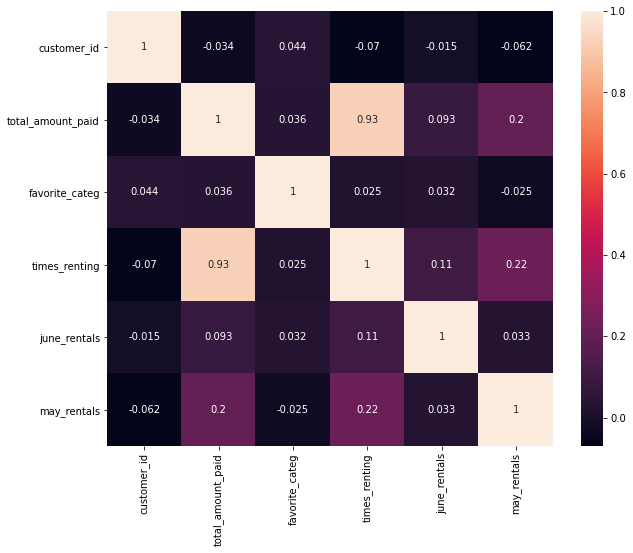

In [4]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [5]:
data.isna().sum()

customer_id          0
city                 0
total_amount_paid    0
favorite_categ       0
times_renting        0
june_rentals         0
may_rentals          0
dtype: int64

In [6]:
data = data.set_index('customer_id')

In [7]:
data

,city,total_amount_paid,favorite_categ,times_renting,june_rentals,may_rentals
customer_id,,,,,,
1,Sasebo,1661.52,4,448,1,2
2,San Bernardino,1673.49,15,351,1,1
3,Athenai,1764.62,1,338,1,2
4,Myingyan,1144.92,11,308,1,0
5,Nantou,2169.30,4,570,1,3
...,...,...,...,...,...,...
595,Jinzhou,1883.20,6,480,1,1
596,Patras,1354.08,15,392,1,6
597,Sullana,1296.75,9,325,1,2


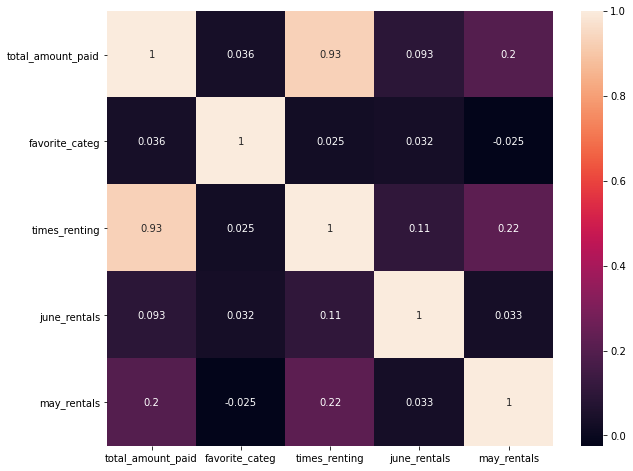

In [8]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [9]:
data1 = data.copy()

In [10]:
data1.dtypes

city                  object
total_amount_paid    float64
favorite_categ         int64
times_renting          int64
june_rentals           int64
may_rentals            int64
dtype: object

In [11]:
data1 = pd.get_dummies(data1)
data1

,total_amount_paid,favorite_categ,times_renting,june_rentals,may_rentals,city_A Corua (La Corua),city_Abha,city_Abu Dhabi,city_Acua,city_Adana,...,city_Zhoushan,city_Ziguinchor,city_al-Ayn,city_al-Hawiya,city_al-Manama,city_al-Qadarif,city_al-Qatif,city_guas Lindas de Gois,city_ostka,city_s-Hertogenbosch
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1661.52,4,448,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1673.49,15,351,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1764.62,1,338,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1144.92,11,308,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2169.30,4,570,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1883.20,6,480,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,1354.08,15,392,1,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,1296.75,9,325,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y = data1['june_rentals']
X = data1.drop('june_rentals', axis=1)

In [13]:
X

,total_amount_paid,favorite_categ,times_renting,may_rentals,city_A Corua (La Corua),city_Abha,city_Abu Dhabi,city_Acua,city_Adana,city_Addis Abeba,...,city_Zhoushan,city_Ziguinchor,city_al-Ayn,city_al-Hawiya,city_al-Manama,city_al-Qadarif,city_al-Qatif,city_guas Lindas de Gois,city_ostka,city_s-Hertogenbosch
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1661.52,4,448,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1673.49,15,351,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1764.62,1,338,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1144.92,11,308,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2169.30,4,570,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1883.20,6,480,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,1354.08,15,392,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,1296.75,9,325,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
classification = LogisticRegression(random_state=42, max_iter = 600)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=600, random_state=42)

In [16]:
classification.score(X_test, y_test)

0.975

In [17]:
predictions = classification.predict(X_test)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [18]:
predictions_ = classification.predict_proba(X_test)
predictions_

array([[4.02409245e-02, 9.59759076e-01],
       [5.33348076e-02, 9.46665192e-01],
       [1.94857389e-03, 9.98051426e-01],
       [1.88206571e-03, 9.98117934e-01],
       [8.23132999e-03, 9.91768670e-01],
       [1.49104760e-03, 9.98508952e-01],
       [9.10983940e-03, 9.90890161e-01],
       [4.67553552e-03, 9.95324464e-01],
       [1.40343536e-02, 9.85965646e-01],
       [1.50368849e-02, 9.84963115e-01],
       [3.86204348e-03, 9.96137957e-01],
       [7.01871495e-04, 9.99298129e-01],
       [7.06116439e-02, 9.29388356e-01],
       [1.79268612e-02, 9.82073139e-01],
       [6.85767010e-02, 9.31423299e-01],
       [1.50001988e-02, 9.84999801e-01],
       [1.92112880e-02, 9.80788712e-01],
       [9.41635787e-03, 9.90583642e-01],
       [2.53771707e-02, 9.74622829e-01],
       [1.22659104e-03, 9.98773409e-01],
       [1.00153288e-02, 9.89984671e-01],
       [1.03565553e-02, 9.89643445e-01],
       [7.53861157e-04, 9.99246139e-01],
       [3.19612673e-03, 9.96803873e-01],
       [1.634883

In [19]:
confusion_matrix(y_test, predictions) # normalize : {'true', 'pred', 'all'}

array([[  0,   3],
       [  0, 117]], dtype=int64)